[['also', 'i', 'was', 'the', 'point', 'person', 'on', 'my', 'company', 'transition', 'from', 'the', 'kl5', 'to', 'gr6', 'system'], ['that', 'i', 'did', 'that', 'i', 'did'], ['my', 'duties', 'all', 'right'], ['i', 'see'], ['good', 'to', 'know'], ['no', 'don', 'i', 'beg', 'of', 'you'], ['hey', 'mon'], ['do', 'i', 'ever'], ['no', 'way'], ['just', 'coffee', 'where', 'are', 'we', 'gonna', 'hang', 'out', 'now'], ['can', 'i', 'get', 'a', 'beer'], ['you', 'betcha'], ['good', 'job', 'joe', 'well', 'done', 'top', 'notch'], ['ohhoho', 'yeah'], ['the', 'whole', 'thing', 'can', 'we', 'go'], ['i', 'love', 'the', 'specifics', 'the', 'specifics', 'were', 'the', 'best', 'part'], ['okay', 'that', 'enough', 'honey'], ['great', 'okay', 'here'], ['can', 'you', 'hold', 'on', 'a', 'moment', 'i', 'have', 'another', 'call', 'i', 'love', 'her'], ['im', 'back'], ['um', 'absolutely', 'uh', 'how', 'bout', 'tomorrow', 'afternoon', 'do', 'you', 'know', 'uh', 'central', 'perk', 'in', 'the', 'village', 'say', 'fiveish

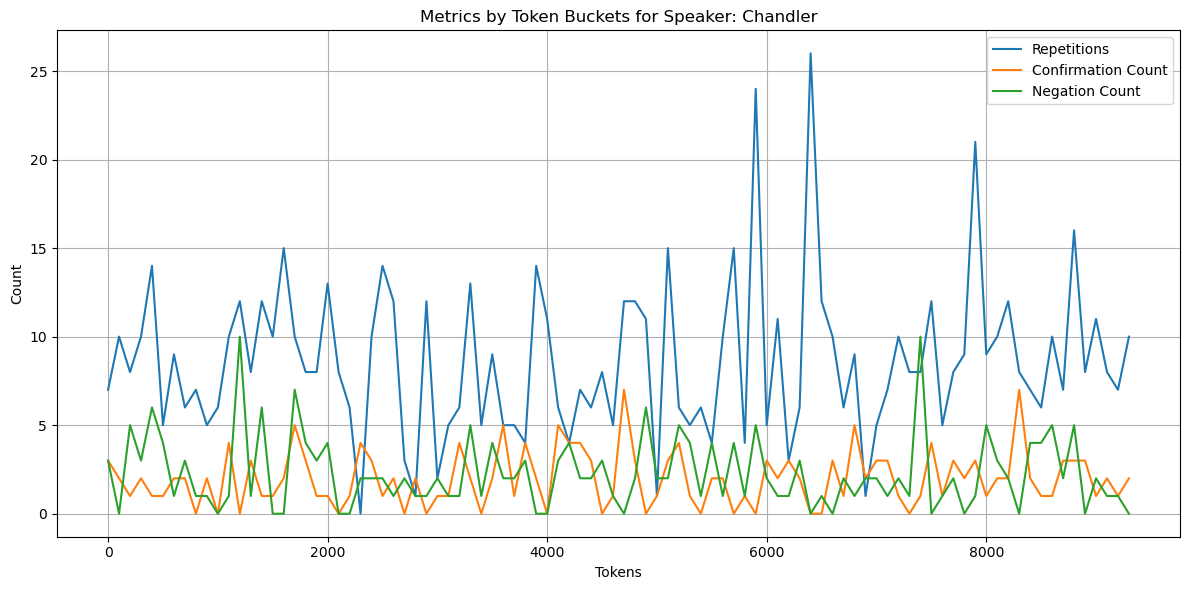

[['but', 'then', 'who', 'the', 'waitress', 'i', 'went', 'out', 'with', 'last', 'month'], ['nononono', 'no', 'who', 'who', 'were', 'you', 'talking', 'about'], ['you', 'liked', 'it', 'you', 'really', 'liked', 'it'], ['which', 'part', 'exactly'], ['oh', 'nonono', 'give', 'me', 'some', 'specifics'], ['hey', 'what', 'about', 'the', 'scene', 'with', 'the', 'kangaroo', 'diddid', 'you', 'like', 'that', 'part'], ['hey', 'so', 'estelle', 'lined', 'up', 'a', 'bunch', 'of', 'auditions', 'for', 'me', 'tomorrow', 'and', 'i', 'll', 'have', 'my', 'health', 'insurance', 'back', 'in', 'no', 'time'], ['what'], ['but', 'um', 'i', 'don', 'think', 'it', 'anything', 'serious'], ['no', 'way', 'kay', 'look', 'if', 'i', 'have', 'to', 'go', 'to', 'the', 'doctor', 'for', 'anything', 'it', 'gonna', 'be', 'for', 'this', 'thing', 'sticking', 'out', 'of', 'my', 'stomach'], ['uhh', 'the', 'ball', 'thing'], ['hey', 'ross', 'wouldnt', 'it', 'be', 'great', 'if', 'we', 'could', 'go', 'two', 'straight', 'hours', 'without',

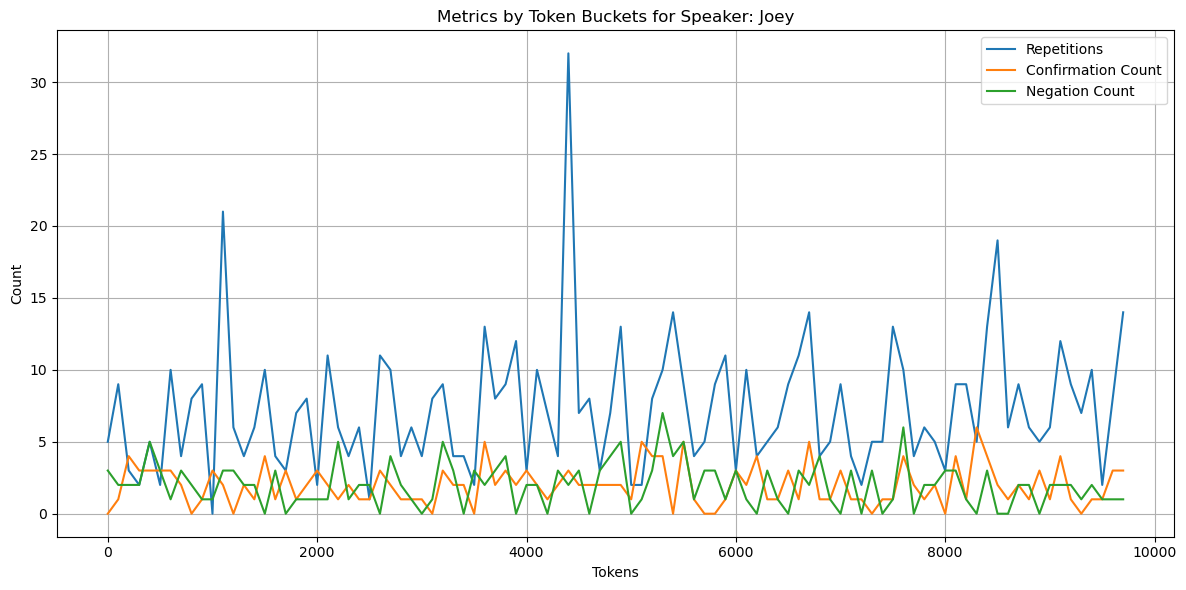

[['you', 'know', 'forget', 'it'], ['hey'], ['what', 'are', 'you', 'doing', 'here'], ['oh'], ['hi'], ['oh', 'well', 'the', 'woman', 'i', 'interviewed', 'with', 'was', 'pretty', 'tough', 'but', 'yknow', 'thank', 'god', 'mark', 'coached', 'me', 'because', 'once', 'i', 'started', 'talking', 'about', 'the', 'fall', 'line', 'she', 'got', 'all', 'happy', 'and', 'wouldn', 'shut', 'up'], ['me', 'too'], ['i', 'know'], ['oh', 'boy', 'i', 'just', 'cant', 'watch', 'its', 'too', 'scary'], ['you', 'guys', 'would', 'never', 'want', 'to', 'go', 'to', 'a', 'lecture', 'with', 'me'], ['now', 'im', 'just', 'letting', 'you', 'know', 'that', 'this', 'is'], ['im', 'sorry', 'im', 'done', 'im', 'done'], ['no', 'not', 'really', 'i', 'mean', 'youve', 'seen', 'me', 'naked', 'hundreds', 'of', 'times'], ['okay', 'all', 'right', 'thats', 'true', 'but', 'yknow', 'i', 'just', 'dont', 'embarrass', 'that', 'easily'], ['no', 'i', 'dont', 'ross', 'i', 'think', 'im', 'just', 'a', 'more', 'secure', 'person', 'than', 'you', '

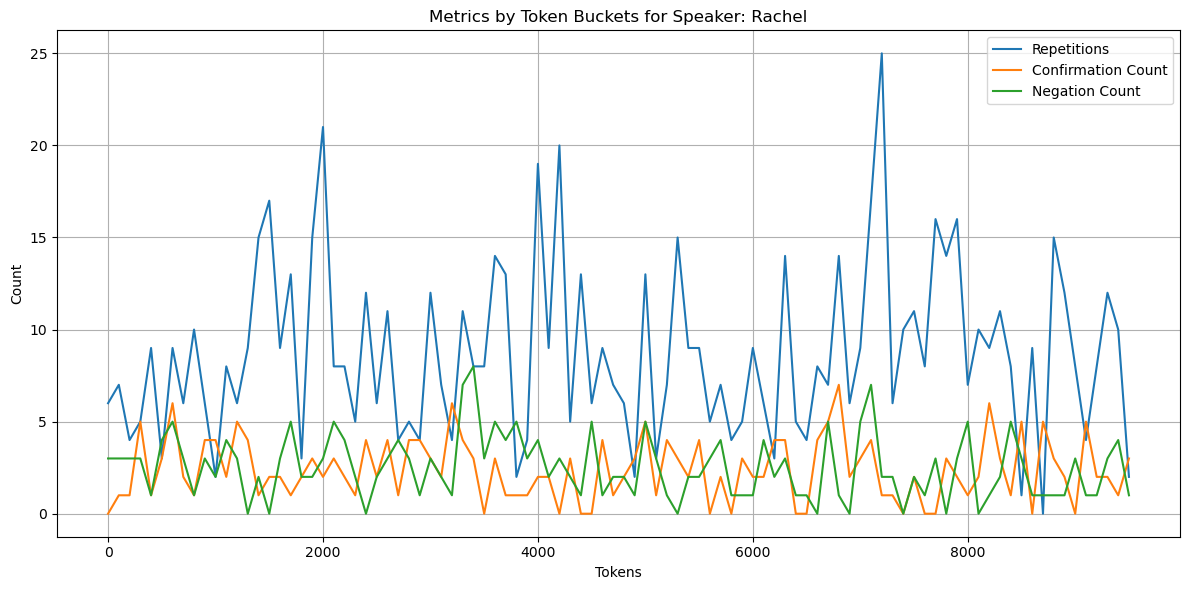

[['heyheyhey', 'you', 'wanna', 'hear', 'something', 'that', 'sucks'], ['chris', 'says', 'they', 're', 'closing', 'down', 'the', 'bar'], ['yeah', 'apparently', 'they', 're', 'turning', 'it', 'into', 'some', 'kinda', 'coffee', 'place'], ['got', 'me'], ['hey', 'did', 'you', 'pick', 'a', 'roommate'], ['rach', 'what', 'are', 'you', 'doing'], ['how', 'does', 'she', 'do', 'that'], ['wow', 'that', 'mike', 'thing', 'was', 'interesting', 'i', 'dont', 'know', 'whats', 'gonna', 'happen', 'with', 'phoebe', 'and', 'david'], ['ok', 'im', 'sensing', 'that', 'this', 'is', 'some', 'kind', 'of', 'word', 'play', 'because', 'you', 'are', 'pink', 'with', 'barely', 'controlled', 'glee'], ['now', 'couldnt', 'you', 'just', 'have', 'made', 'some', 'sort', 'of', 'inappropriate', 'joke'], ['hi', 'guys'], ['okay', 'we', 'have', 'a', 'lot', 'of', 'options', 'here', 'a', 'number', 'of', 'prototypes', 'for', 'you', 'to', 'try', 'on'], ['you', 'kissed', 'another', 'woman'], ['hello', 'eighth', 'street', 'deli'], ['uh'

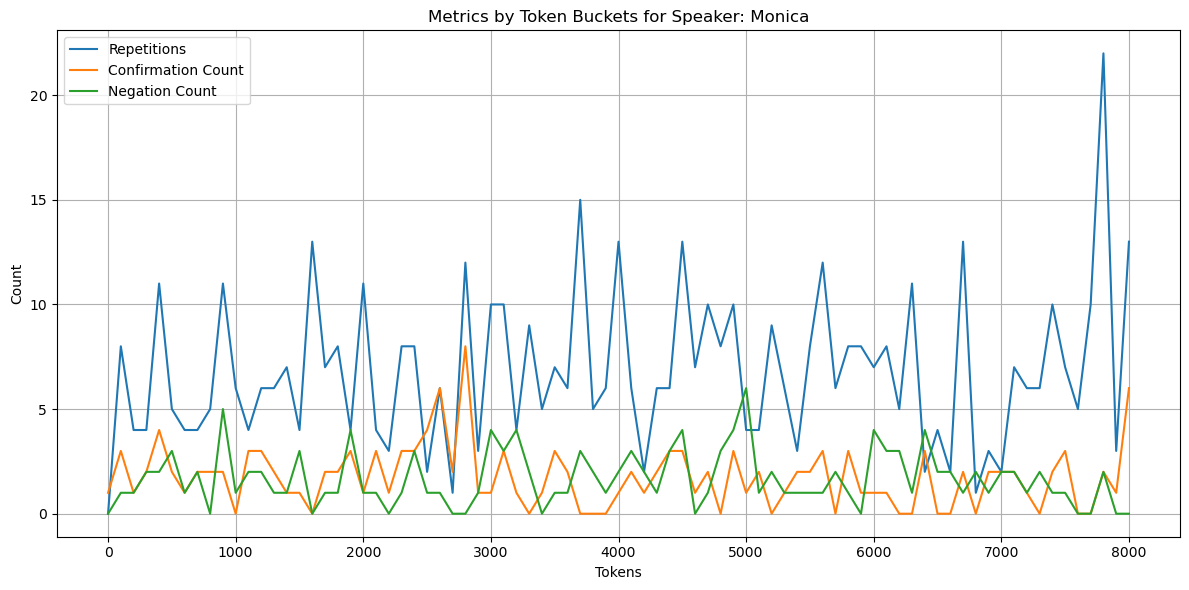

[['oh', 'my', 'god', 'oh', 'my', 'god', 'poor', 'monica'], ['american'], ['oy'], ['i', 'got', 'no', 'sleep', 'last', 'night'], ['you', 'have', 'no', 'idea', 'how', 'loud', 'they', 'are'], ['oh', 'yeah', 'im', 'sure', 'and', 'all', 'of', 'a', 'sudden', 'his', 'hands', 'werent', 'the', 'problem', 'anymore'], ['oh', 'boy', 'scouts', 'could', 'have', 'camped', 'under', 'there'], ['ooh', 'i', 'have', 'to', 'tell', 'you', 'something'], ['but', 'i', 'can', 'tell', 'you'], ['well', 'sure', 'in', 'a', 'perfect', 'world', 'but', 'no', 'i', 'promised', 'i', 'wouldn', 'tell', 'and', 'i', 'swore', 'to', 'like', 'all', 'my', 'gods'], ['no'], ['no'], ['personal', 'shopping', 'what', 'is', 'that', 'like', 'where', 'you', 'walk', 'around', 'with', 'snooty', 'rich', 'people', 'and', 'tell', 'them', 'what', 'to', 'buy'], ['with', 'what'], ['oo', 'you', 'should', 'have', 'one', 'of', 'us', 'do', 'it'], ['no', 'no', 'it', 'sit', 'uh', 'a', 'real', 'thing', 'anyone', 'can', 'get', 'ordained', 'on', 'the', '

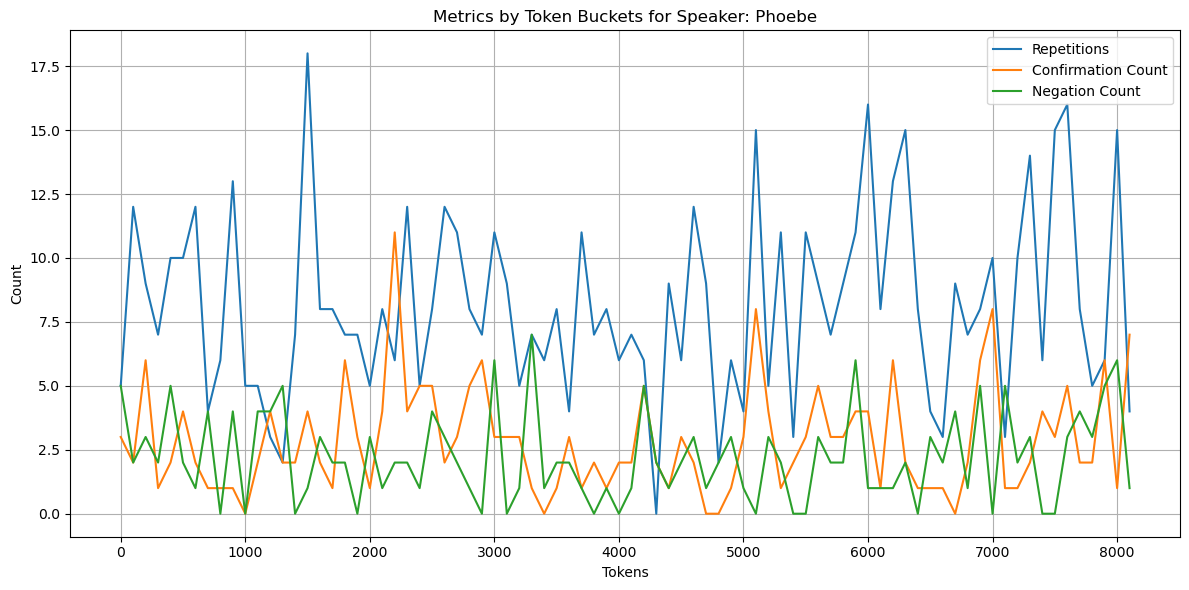

[['hi'], ['ah', 'yknow', 'this', 'building', 'is', 'on', 'my', 'paper', 'route', 'so', 'i'], ['hi'], ['how', 'd', 'did', 'it', 'go'], ['i', 'm', 'so', 'proud', 'of', 'you'], ['listen', 'i', 'm', 'ah', 'i', 'm', 'sorry', 'i', 've', 'been', 'so', 'crazy', 'and', 'jealous', 'and', 'it', 'just', 'that', 'i', 'like', 'you', 'a', 'lot', 'so'], ['even', 'though', 'you', 'do', 'do', 'a', 'good', 'bob', 'impression', 'im', 'thinkin', 'when', 'she', 'sees', 'you', 'tomorow', 'shes', 'probably', 'gonna', 'realize', 'hey', 'youre', 'not', 'bob'], ['this', 'is', 'my', 'wedding'], ['uh', 'that', 'an', 'eighteenth', 'century', 'indian', 'artifact', 'from', 'calcutta'], ['well', 'well', 'to', 'sum', 'up', 'we', 're', 'having', 'fun', 'you', 'look', 'young'], ['but', 'that', 'not', 'enough', 'so', 'so', 'here', 'a', 'key', 'to', 'my', 'apartment'], ['get', 'out'], ['yes', 'please', 'so', 'whats', 'going', 'on'], ['oh', 'my', 'god', 'whwhat', 'happened'], ['i', 'knew', 'that', 'was', 'him'], ['ill', 'ge

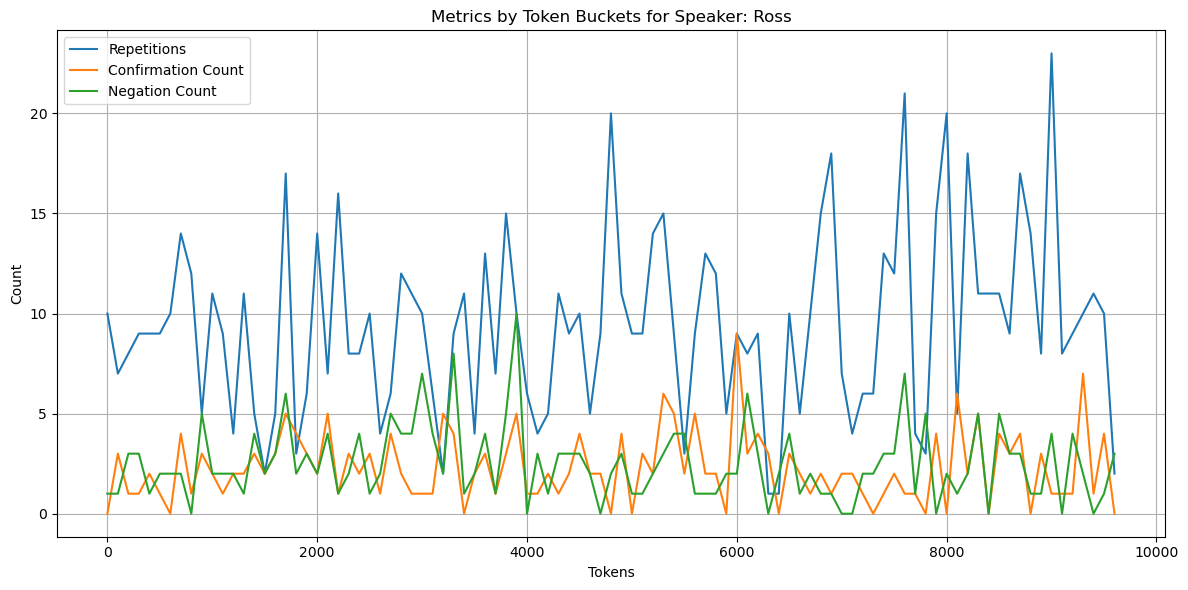

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np

# Define your words sets
confirmation_words = {'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither', "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't", "don", "isn", "wasn", "doesn", "won", "haven"}
# added "don", "isn", "wasn", "doesn", "won", "haven"
stop_words = {'t', 's'}

def preprocess(tokens):
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]

def calculate_row_metrics(speaker_df):
    # Metrics per row
    all_tokens = []
    token_sizes = []
    repetitions = []
    confirmation_counts = []
    negation_counts = []

    for _, row in speaker_df.iterrows():
        tokens = row['Utterance_1'].split()
        tokens = preprocess(tokens)
        all_tokens.append(tokens)

        # Token size
        token_size = len(tokens)
        token_sizes.append(token_size)

        # Word counts
        word_counts = Counter(tokens)
        
        # Calculations
        repetition_count = sum(count - 1 for word, count in word_counts.items() if count > 1)
        repetitions.append(repetition_count)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        confirmation_counts.append(confirmation_count)

        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)
        negation_counts.append(negation_count)

    speaker_df['Tokens'] = all_tokens
    speaker_df['Token Size'] = token_sizes
    speaker_df['Repetitions'] = repetitions
    speaker_df['Confirmation Count'] = confirmation_counts
    speaker_df['Negation Count'] = negation_counts

    print(all_tokens)
    return speaker_df

def calculate_bucket_metrics(speaker_df, bucket_size=100):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmation Count': [],
        'Negation Count': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = row['Token Size']
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmation Count'].append(bucket_confirmations)
            bucket_metrics['Negation Count'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmation Count']
        bucket_negations += row['Negation Count']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmation Count'].append(bucket_confirmations)
        bucket_metrics['Negation Count'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)

def calculate_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmation Count'].values)
    total_negations = sum(speaker_df['Negation Count'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics

def calculate_average_personality(speaker_df):
    personality_columns = ['Personality']
    averages = {trait: eval(speaker_df[trait].iloc[0]) for trait in personality_columns}
    return averages

# Load your data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames with each subset being a copy of the relevant data
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


df_metrics = pd.DataFrame(all_metrics).T

In [2]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
Chandler,1620,9378,810,186,214
Joey,1621,9792,714,194,193
Rachel,1429,9600,836,229,241
Monica,1492,8076,552,141,136
Phoebe,1479,8139,667,233,180
Ross,1557,9657,911,222,242


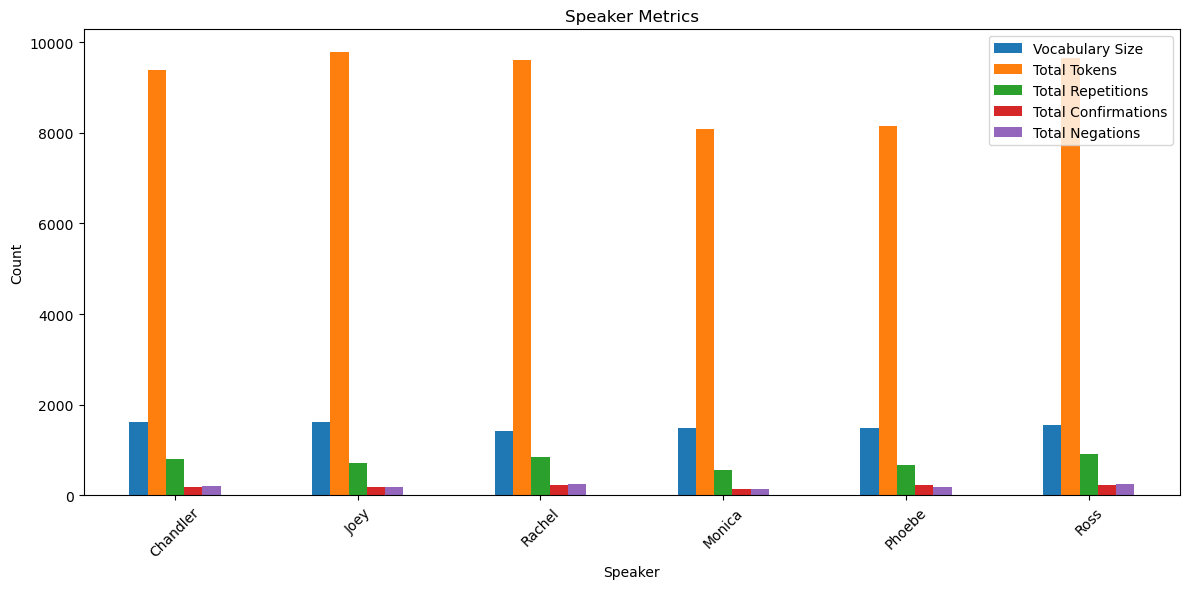

In [3]:
df_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Speaker Metrics')
plt.ylabel('Count')
plt.xlabel('Speaker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Gather all tokens across all utterances
all_tokens = []

for utterance in df['Utterance_1']:
    tokens = preprocess(utterance.split())
    all_tokens.extend(tokens)

# Count token occurrences and get the 30 most common tokens
token_counts = Counter(all_tokens)
top_30_tokens = token_counts.most_common(100)

# Display the result
for token, count in top_30_tokens:
    print(f"{token}: {count}")


i: 2463
you: 2226
the: 1241
a: 1040
to: 1026
it: 923
that: 811
oh: 756
what: 736
and: 721
is: 570
me: 549
no: 540
this: 505
yeah: 483
just: 477
so: 474
my: 460
okay: 453
know: 451
of: 431
in: 428
hey: 424
we: 412
do: 405
have: 379
well: 376
was: 357
not: 347
with: 339
on: 335
are: 330
but: 304
for: 299
right: 298
im: 296
can: 283
all: 278
out: 258
like: 256
be: 254
m: 243
your: 240
uh: 235
about: 233
get: 233
its: 231
go: 230
he: 229
gonna: 228
here: 227
she: 210
really: 210
think: 199
how: 192
look: 191
her: 187
dont: 187
got: 185
don: 181
mean: 179
one: 176
there: 176
up: 173
if: 171
now: 169
did: 168
re: 167
god: 163
hi: 159
they: 155
at: 154
were: 153
want: 152
why: 150
him: 147
ross: 138
yknow: 137
come: 136
sorry: 132
ok: 132
see: 131
good: 131
youre: 126
going: 124
tell: 117
joey: 117
great: 115
thats: 114
yes: 113
when: 112
little: 109
say: 108
would: 106
some: 102
had: 102
umm: 101
because: 97
guys: 97
ah: 96


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6510 entries, 0 to 6509
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Speaker_1    6510 non-null   object
 1   Speaker_2    6510 non-null   object
 2   Personality  6510 non-null   object
 3   Utterance_1  6510 non-null   object
 4   Utterance_2  6510 non-null   object
 5   Utterance_3  6510 non-null   object
 6   Emotion_1    6510 non-null   object
 7   Emotion_2    6510 non-null   object
 8   Emotion_3    6510 non-null   object
 9   Sentiment_1  6510 non-null   object
 10  Sentiment_2  6510 non-null   object
 11  Sentiment_3  6510 non-null   object
dtypes: object(12)
memory usage: 610.4+ KB


In [6]:
speaker_dfs['Joey'].tail(200)

,Speaker_1,Speaker_2,Personality,Utterance_1,Utterance_2,Utterance_3,Emotion_1,Emotion_2,Emotion_3,Sentiment_1,Sentiment_2,Sentiment_3,Tokens,Token Size,Repetitions,Confirmation Count,Negation Count
5302,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]",Huh.,What?,"No I just uh, thought you liked your eggs with...",neutral,neutral,neutral,neutral,neutral,neutral,[huh],1,0,0,0
5307,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]","Hey, this isn't about juice anymore, alright man.","Alright, so what's it about?","Eggs. Who's eggs do you like better, his or mi...",anger,neutral,anger,negative,neutral,negative,"[hey, this, isnt, about, juice, anymore, alrig...",8,0,1,0
5309,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]","Eggs. Who's eggs do you like better, his or mi...",Well I like both eggs equally.,Oh come on. Nobody likes two different kinds o...,anger,neutral,anger,negative,neutral,negative,"[eggs, whos, eggs, do, you, like, better, his,...",11,1,0,0
5329,Joey,Estelle,"[0.574, 0.614, 0.297, 0.545, 0.455]","So, you're not mad at me for getting fired and...","Joey, look at me, look at me. Do I have lipsti...","No, can we get back to me?",fear,neutral,fear,negative,neutral,negative,"[so, youre, not, mad, at, me, for, getting, fi...",11,0,0,1
5330,Joey,Estelle,"[0.574, 0.614, 0.297, 0.545, 0.455]",But I was Dr. Drake Remoray. How can I go from...,"Things change, roll with em.","But this is a two line part, it's like takin' ...",fear,neutral,neutral,negative,neutral,neutral,"[but, i, was, dr, drake, remoray, how, can, i,...",18,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]","Look, we're not throwing it out! I built this ...","All right, how about we, how 'bout we sell it.","All right. But, you're gonna have to tell them.",anger,neutral,sadness,negative,neutral,negative,"[look, were, not, throwing, it, out, i, built,...",14,0,0,1
6476,Joey,Phoebe,"[0.574, 0.614, 0.297, 0.545, 0.455]","Uh, Pheebs, about your mom...",Yeah?,How's that going?,neutral,neutral,neutral,neutral,neutral,neutral,"[uh, pheebs, about, your, mom]",5,0,0,0
6477,Joey,Guy,"[0.574, 0.614, 0.297, 0.545, 0.455]",Oh yeah! I got in there myself once. My roomma...,"No, you, you can't fit in that thing. That's n...","Oh yeah? If I can't, I'll knock five bucks off...",neutral,fear,neutral,neutral,negative,neutral,"[oh, yeah, i, got, in, there, myself, once, my...",44,10,2,0
6478,Joey,Guy,"[0.574, 0.614, 0.297, 0.545, 0.455]","Oh yeah? If I can't, I'll knock five bucks off...","All right, you have yourself a deal.",Okay. See?! I told ya!,neutral,joy,neutral,neutral,positive,neutral,"[oh, yeah, if, i, cant, ill, knock, five, buck...",15,2,1,0


In [7]:
all_personality_averages

{'Chandler': {'Personality': [0.648, 0.375, 0.386, 0.58, 0.477]},
 'Joey': {'Personality': [0.574, 0.614, 0.297, 0.545, 0.455]},
 'Rachel': {'Personality': [0.635, 0.354, 0.521, 0.552, 0.469]},
 'Monica': {'Personality': [0.713, 0.457, 0.457, 0.66, 0.511]},
 'Phoebe': {'Personality': [0.6, 0.48, 0.31, 0.46, 0.56]},
 'Ross': {'Personality': [0.722, 0.489, 0.6, 0.533, 0.356]}}

# Task 6
## Create and split training/testing datasets

### Import frameworks

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Input
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Load Dataset and split labels

In [10]:
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)


labels = df['Personality'].to_numpy()
labels = [eval(x) for x in labels]
df_labels = pd.DataFrame(labels, columns=['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism'])

### Function for creating training datasets with different variables

In [11]:
def get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(n_gram,n_gram))


    # Utterance 1 is always True
    utterance_tfidf = tfidf.fit_transform(df['Utterance_1'])
    df_features = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance1_{word}" for word in tfidf.get_feature_names_out()])
    if emotion:
        df_emotions = pd.get_dummies(df[['Emotion_1']])
        df_features = pd.concat([df_features, df_emotions], axis=1)
    if sentiment:
        df_sentiments = pd.get_dummies(df[['Sentiment_1']])
        df_features = pd.concat([df_features, df_sentiments], axis=1)



    if utterance_2:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_2'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance2_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_2']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_2']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)


    if utterance_3:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_3'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance3_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_3']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_3']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)

    # Train-test split
    features_train, features_test, labels_train, labels_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])

    return features_train, features_test, labels_train, labels_test

### Setup 6 different ai models to do parameter hypertuning with gridsearch on
This is so we can check which models performs best on our dataset, with several different parameters.

Note, for now we only use deep learning as this takes a long time to search, it is also unnecesary to hyper optimize for this assignment as the course is about Processing Natural Language


In [12]:

# Deep learning model function
def create_deep_learning_model(input_dim, dense_units=512, dropout_rate=0.5):
    model = Sequential([
        Input(shape=(input_dim,)),  # Define the input layer with the shape
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def grid_search_deep_learning(features_train, labels_train):
    model = KerasRegressor(
        model=create_deep_learning_model,
        input_dim=features_train.shape[1],
        verbose=0
    )
    
    # Define the param_grid with parameter names directly available in KerasRegressor
    param_grid = {
        'model__dense_units': [512, 256],
        'model__dropout_rate': [0.3, 0.5],
        'epochs': [10],
        'batch_size': [16, 32]
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Deep Learning Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Linear regression model function
def grid_search_linear_regression(features_train, labels_train):
    model = LinearRegression()
    multi_target_lr = MultiOutputRegressor(model)  # Wrap in MultiOutputRegressor
    param_grid = {}
    
    grid_search = GridSearchCV(estimator=multi_target_lr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Linear Regression Params:", grid_search.best_params_)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Polynomial regression model function
def grid_search_polynomial_regression(features_train, labels_train):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    
    multi_target_poly = MultiOutputRegressor(model)  # Wrap in MultiOutputRegressor
    param_grid = {
        'estimator__poly__degree': [2, 3]  # Adjust the parameter for the pipeline
    }
    
    grid_search = GridSearchCV(estimator=multi_target_poly, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Polynomial Regression Params:", grid_search.best_params_)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# SVR model function
def grid_search_svr(features_train, labels_train):
    # Initialize SVR model
    model = SVR()
    
    # Define parameter grid
    param_grid = {
        'estimator__kernel': ['linear', 'rbf', 'poly'],
        'estimator__C': [0.1, 1, 10],
        'estimator__epsilon': [0.01, 0.1, 1]
    }
    
    # Use MultiOutputRegressor with GridSearchCV
    multi_target_svr = MultiOutputRegressor(model)
    grid_search = GridSearchCV(estimator=multi_target_svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the model
    grid_search.fit(features_train, labels_train)
    
    print("Best SVR Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Decision tree model function
def grid_search_decision_tree(features_train, labels_train):
    model = DecisionTreeRegressor()
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 16]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Decision Tree Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Random forest model function
def grid_search_random_forest(features_train, labels_train):
    model = RandomForestRegressor()
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Random Forest Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_

### Run grid search on all models
Note, as specified earlier, there is not enough time for this task that doesn't contribute to the field of NLP.

Therefore, we comment it out for now.

In [13]:
#print(features_train.shape)

# # Linear regression model
# best_linear_model, best_params_lr, best_params_lr_repeat, best_score_lr = grid_search_linear_regression(features_train, labels_train)
# print(f"Best Linear Model: {best_linear_model}")
# print(f"Best Parameters (Linear Regression): {best_params_lr}")
# print(f"Repeated Best Parameters (Linear Regression): {best_params_lr_repeat}")
# print(f"Best Score (Linear Regression): {best_score_lr}")

# # Polynomial regression model
# best_polynomial_model, best_params_poly, best_params_poly_repeat, best_score_poly = grid_search_polynomial_regression(features_train, labels_train)
# print(f"Best Polynomial Model: {best_polynomial_model}")
# print(f"Best Parameters (Polynomial Regression): {best_params_poly}")
# print(f"Repeated Best Parameters (Polynomial Regression): {best_params_poly_repeat}")
# print(f"Best Score (Polynomial Regression): {best_score_poly}")

# # for dataframe in df_features_array:

# # SVR model
# # Train-test split
# features_train, features_test, labels_train, labels_test = train_test_split(dataframe, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
# best_svr_model, best_params_svr, best_params_svr_repeat, best_score_svr = grid_search_svr(features_train, labels_train)
# print(f"Best SVR Model: {best_svr_model}")
# print(f"Best Parameters (SVR): {best_params_svr}")
# print(f"Repeated Best Parameters (SVR): {best_params_svr_repeat}")
# print(f"Best Score (SVR): {best_score_svr}")

# # Decision tree model
# best_decision_tree_model, best_params_dt, best_params_dt_repeat, best_score_dt = grid_search_decision_tree(features_train, labels_train)
# print(f"Best Decision Tree Model: {best_decision_tree_model}")
# print(f"Best Parameters (Decision Tree): {best_params_dt}")
# print(f"Repeated Best Parameters (Decision Tree): {best_params_dt_repeat}")
# print(f"Best Score (Decision Tree): {best_score_dt}")

# # Random forest model
# best_random_forest_model, best_params_rf, best_params_rf_repeat, best_score_rf = grid_search_random_forest(features_train, labels_train)
# print(f"Best Random Forest Model: {best_random_forest_model}")
# print(f"Best Parameters (Random Forest): {best_params_rf}")
# print(f"Repeated Best Parameters (Random Forest): {best_params_rf_repeat}")
# print(f"Best Score (Random Forest): {best_score_rf}")

# # Deep learning model
# best_deep_learning_model, best_params_dl, best_params_dl_repeat, best_score_dl = grid_search_deep_learning(features_train, labels_train)
# print(f"Best Deep Learning Model: {best_deep_learning_model}")
# print(f"Best Parameters (Deep Learning): {best_params_dl}")
# print(f"Repeated Best Parameters (Deep Learning): {best_params_dl_repeat}")
# print(f"Best Score (Deep Learning): {best_score_dl}")

### Run grid search only one a deep learning model
Therefore we only run grid search on deep learning, and not all models

In [14]:
features_train, features_test, labels_train, labels_test = get_training_labels()


# Deep learning model
best_deep_learning_model, best_params_dl, best_params_dl_repeat, best_score_dl = grid_search_deep_learning(features_train, labels_train)
print(f"Best Deep Learning Model: {best_deep_learning_model}")
print(f"Best Parameters (Deep Learning): {best_params_dl}")
print(f"Repeated Best Parameters (Deep Learning): {best_params_dl_repeat}")
print(f"Best Score (Deep Learning): {best_score_dl}")

KeyboardInterrupt: 

The best deep learning parameters for this problem are these:

batch_size: 32

epochs: 10

model__dense_units: 256

model__dropout_rate: 0.5

In [15]:
best_params = {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}

### Create a list of datasets that differs in simple terms
This is the meat of this task. We want to determine how different features affect the model.

Therefore we start by making only one or two changes in each dataset in order to be able to measure the impact of every single feature

In [16]:
training_datasets = {
    "all_data": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "5000features": list(get_training_labels(max_features=5000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "1000features": list(get_training_labels(max_features=1000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "bigram": list(get_training_labels(max_features=None, n_gram=2, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram": list(get_training_labels(max_features=None, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "quadgram": list(get_training_labels(max_features=None, n_gram=4, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "no_sentiment": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=False, utterance_2=True, utterance_3=True)),
    "no_emotion": list(get_training_labels(max_features=None, n_gram=1, emotion=False, sentiment=True, utterance_2=True, utterance_3=True)),
    "no_emotion_or_sentiment": list(get_training_labels(max_features=None, n_gram=1, emotion=False, sentiment=False, utterance_2=True, utterance_3=True)),

    "no_utterance2": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=True)),
    "only_utterance1": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=False))
}

KeyboardInterrupt: 

### Create a function for running the model on all datasets
We split the 'train' into 'train/val', so that we have training, validation and testing

In [17]:
def run_deep_learning_model_with_params(features_train, features_test, labels_train, labels_test, params):
    # Extract parameters from the dictionary
    dense_units = params.get('model__dense_units', 512)
    dropout_rate = params.get('model__dropout_rate', 0.5)
    epochs = params.get('epochs', 10)
    batch_size = params.get('batch_size', 32)
    
    # Train-val split
    df_full_train, df_full_test, labels_train, labels_test = train_test_split(df, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
    features_inner_train, features_val, labels_inner_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42, stratify=df_full_train['Speaker_1'])

    # Define the model architecture based on chosen parameters
    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    history = model.fit(features_inner_train, labels_inner_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(features_val, labels_val),
                        verbose=1)
    
    # Evaluate the model on the test set
    test_loss = model.evaluate(features_test, labels_test)
    print(f"Test Loss: {test_loss}")
    
    return test_loss

### Run the model on every dataset to compare test loss

In [ ]:
test_losses = {}

# Loop through each dataset in training_datasets
for dataset_name, (features_train, labels_train, features_test, labels_test) in training_datasets.items():
    print(f"Model: {dataset_name}")
    # Run the model with the specified parameters and get the test loss
    test_loss = run_deep_learning_model_with_params(features_train, labels_train, features_test, labels_test, best_params)
    # Save the test loss in the test_losses dictionary with the dataset name as the key
    test_losses[dataset_name] = test_loss
    print(f"{dataset_name}: {test_loss}")


Model: all_data
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0581 - val_loss: 0.0069
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0052 - val_loss: 0.0076
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0014 - val_loss: 0.0059
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Test Loss: 0.0058225891552865505
all_data: 0.00582258915528

In [ ]:
# Print all test losses sorted from least to most loss
print("Test Losses (sorted):")
for dataset, loss in sorted(test_losses.items(), key=lambda item: item[1]):
    print(f"{dataset}: {loss}")

Test Losses (sorted):
trigram: 0.005757459439337254
5000features: 0.005766735412180424
no_emotion: 0.005812237039208412
quadgram: 0.0058181206695735455
no_emotion_or_sentiment: 0.005820064339786768
all_data: 0.0058225891552865505
no_utterance2: 0.005976484622806311
1000features: 0.006012726575136185
bigram: 0.006078173406422138
no_sentiment: 0.0061368318274617195
only_utterance1: 0.00617994274944067


### Datasets comparison

The test losses, ordered from least loss to most loss, are as follows:

- trigram:                  0.005757459439337254
- 5000features:             0.005766735412180424
- no_emotion:               0.005812237039208412
- quadgram:                 0.0058181206695735455
- no_emotion_or_sentiment:  0.005820064339786768
- all_data:                 0.0058225891552865505
- no_utterance2:            0.005976484622806311
- 1000features:             0.006012726575136185
- bigram:                   0.006078173406422138
- no_sentiment:             0.0061368318274617195
- only_utterance1:          0.00617994274944067


Let's break these down

The baseline is 'all_data' as that is just the raw dataset, so we use this to compare the changes with.

#### Limited Vocabulary 
Limiting it to 5000 features is very roughly limiting it to slightly above half. This did make a noticeable improvement.

Limiting the vocabulary to 1000 seemed to make the model worse.

This seems to indicate that the least frequent words yields too little information about personality, relative to more frequent words. But you might only want to cut off a certain bottom percentile.

We should test with a broader vocabulary and also somewhere between 1000-5000

Let's make a test for both 3000 and 7000


#### N-Gram
trigram made a noticeable improvement over bigram, quadgram, and unigram.

This might indicate that trigram is optimal in capturing the personality of a speaker, as it hits a middleground of splitting up tokens.


#### Emotion
The emotion tags seems to not make a noticeable difference.


#### Sentiment
Removing sentiment seems to be detrimental to the model, however, if you remove both emotions and sentiment, then the performance goes back to baseline.

We can speculate on why this is the case.

There might be information in sentiment that only makes sense to the model together with emotion.


#### Utterances
It makes intuitive sense that removing utterance 3 (Speaker 1's second utternace) makes the model worse.

However, it is interesting that utterance 2 (Speaker 2's utternace) contributes to the models performance when combined with utterance 3


### Further testing

We should test some of these features more, and also a combination of them

In [18]:
training_datasets_2 = {
    "7000features": list(get_training_labels(max_features=7000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "3000features": list(get_training_labels(max_features=3000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "trigram_5000features": list(get_training_labels(max_features=5000, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram_5000features_noEmotion": list(get_training_labels(max_features=5000, n_gram=3, emotion=False, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram_5000features_noEmotion_noSentiment": list(get_training_labels(max_features=5000, n_gram=3, emotion=False, sentiment=False, utterance_2=True, utterance_3=True)),
}

KeyboardInterrupt: 

In [ ]:
test_losses_2 = {}

# Loop through each dataset in training_datasets
for dataset_name, (features_train, labels_train, features_test, labels_test) in training_datasets_2.items():
    print(f"Model: {dataset_name}")
    # Run the model with the specified parameters and get the test loss
    test_loss = run_deep_learning_model_with_params(features_train, labels_train, features_test, labels_test, best_params)
    # Save the test loss in the test_losses dictionary with the dataset name as the key
    test_losses_2[dataset_name] = test_loss
    print(f"{dataset_name}: {test_loss}")


Model: 7000features
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0587 - val_loss: 0.0069
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0051 - val_loss: 0.0075
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0013 - val_loss: 0.0059
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Test Loss: 0.005921616684645414
7000features: 0.0059216

In [ ]:
# Print all test losses for the previous test sorted from least to most loss
print("Test Losses for previous test (sorted):")
for dataset, loss in sorted(test_losses.items(), key=lambda item: item[1]):
    print(f"{dataset}: {loss}")

# Print all test losses for this test sorted from least to most loss
print("\nTest Losses for this test (sorted):")
for dataset, loss in sorted(test_losses_2.items(), key=lambda item: item[1]):
    print(f"{dataset}: {loss}")

Test Losses for previous test (sorted):
trigram: 0.005757459439337254
5000features: 0.005766735412180424
no_emotion: 0.005812237039208412
quadgram: 0.0058181206695735455
no_emotion_or_sentiment: 0.005820064339786768
all_data: 0.0058225891552865505
no_utterance2: 0.005976484622806311
1000features: 0.006012726575136185
bigram: 0.006078173406422138
no_sentiment: 0.0061368318274617195
only_utterance1: 0.00617994274944067

Test Losses for this test (sorted):
3000features: 0.005785919725894928
7000features: 0.005921616684645414
trigram_5000features: 0.006059326231479645
trigram_5000features_noEmotion: 0.006188692059367895
trigram_5000features_noEmotion_noSentiment: 0.006352831143885851


In [ ]:
# Combine the two dictionaries into one list with a flag for highlighting
combined_losses = [(dataset, loss, 'second' if dataset in test_losses_2 else 'first') for dataset, loss in test_losses.items()]
combined_losses.extend([(dataset, loss, 'second') for dataset, loss in test_losses_2.items()])

# Sort the combined list by the loss value
combined_losses.sort(key=lambda item: item[1])

# Print the sorted losses with highlighting
print("Combined Test Losses (sorted):")
for dataset, loss, source in combined_losses:
    if source == 'second':
        print(f"* {dataset}: {loss}")  # Highlight the dataset from the second test
    else:
        print(f"{dataset}: {loss}")

Combined Test Losses (sorted):
trigram: 0.005757459439337254
5000features: 0.005766735412180424
* 3000features: 0.005785919725894928
no_emotion: 0.005812237039208412
quadgram: 0.0058181206695735455
no_emotion_or_sentiment: 0.005820064339786768
all_data: 0.0058225891552865505
* 7000features: 0.005921616684645414
no_utterance2: 0.005976484622806311
1000features: 0.006012726575136185
* trigram_5000features: 0.006059326231479645
bigram: 0.006078173406422138
no_sentiment: 0.0061368318274617195
only_utterance1: 0.00617994274944067
* trigram_5000features_noEmotion: 0.006188692059367895
* trigram_5000features_noEmotion_noSentiment: 0.006352831143885851


In [2]:
def get_training_labels_pca(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(n_gram, n_gram))

    # Utterance 1 is always True
    utterance_tfidf = tfidf.fit_transform(df['Utterance_1'])
    df_features = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance1_{word}" for word in tfidf.get_feature_names_out()])
    
    if emotion:
        df_emotions = pd.get_dummies(df[['Emotion_1']])
        df_features = pd.concat([df_features, df_emotions], axis=1)
    if sentiment:
        df_sentiments = pd.get_dummies(df[['Sentiment_1']])
        df_features = pd.concat([df_features, df_sentiments], axis=1)

    if utterance_2:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_2'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance2_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_2']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_2']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)

    if utterance_3:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_3'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance3_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_3']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_3']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)

    # Assuming df_labels is defined elsewhere in your code
    df_labels = df['Speaker_1']  # Adjust according to your dataset

    # Train-test split
    features_train, features_test, labels_train, labels_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])

    # Standardize the features before applying PCA
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)

    # Apply PCA to keep 90% of the variance
    pca = PCA(n_components=0.10)
    features_train_pca = pca.fit_transform(features_train_scaled)
    features_test_pca = pca.transform(features_test_scaled)

    return features_train_pca, features_test_pca, labels_train, labels_test

In [3]:
training_datasets_pca = {
    "all_data": list(get_training_labels_pca(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "5000features": list(get_training_labels_pca(max_features=5000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "1000features": list(get_training_labels_pca(max_features=1000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "bigram": list(get_training_labels_pca(max_features=None, n_gram=2, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram": list(get_training_labels_pca(max_features=None, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "quadgram": list(get_training_labels_pca(max_features=None, n_gram=4, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "no_sentiment": list(get_training_labels_pca(max_features=None, n_gram=1, emotion=True, sentiment=False, utterance_2=True, utterance_3=True)),
    "no_emotion": list(get_training_labels_pca(max_features=None, n_gram=1, emotion=False, sentiment=True, utterance_2=True, utterance_3=True)),
    "no_emotion_or_sentiment": list(get_training_labels_pca(max_features=None, n_gram=1, emotion=False, sentiment=False, utterance_2=True, utterance_3=True)),

    "no_utterance2": list(get_training_labels_pca(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=True)),
    "only_utterance1": list(get_training_labels_pca(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=False))
}


training_datasets_2_pca = {
    "7000features": list(get_training_labels_pca(max_features=7000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "3000features": list(get_training_labels_pca(max_features=3000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "trigram_5000features": list(get_training_labels_pca(max_features=5000, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram_5000features_noEmotion": list(get_training_labels_pca(max_features=5000, n_gram=3, emotion=False, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram_5000features_noEmotion_noSentiment": list(get_training_labels_pca(max_features=5000, n_gram=3, emotion=False, sentiment=False, utterance_2=True, utterance_3=True))
}

NameError: name 'TfidfVectorizer' is not defined